# LSTM 모형 비교(Public Score : 0.847) 
---
코드공유 : https://dacon.io/competitions/official/235864/codeshare/4180?page=1&dtype=recent

필사전에 참고할 기본 코드
1. [데이콘 EDA](https://dacon.io/competitions/official/235864/codeshare/4127?page=1&dtype=recent)
2. [데이콘 Base line code](https://dacon.io/competitions/official/235864/codeshare/4142?page=1&dtype=recent)

# 1. 데이터 로드

In [ ]:
# 현재 작업 경로를 얻는 함수
import os
print(os.getcwd())

/content


In [ ]:
#데이터 불러오기
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Aiffel/03_Kaggle_Dacon/20220115_영화리뷰감성분석/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Aiffel/03_Kaggle_Dacon/20220115_영화리뷰감성분석/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Aiffel/03_Kaggle_Dacon/20220115_영화리뷰감성분석/sample_submission.csv')

In [ ]:
train.head(3)

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1


In [ ]:
test.head(3)

,id,document
0,1,시간 때우기 좋은 영화 지루함
1,2,훈훈한 정이 느껴지는 영화! 가족끼리 드라마 보듯이 보면 딱~!
2,3,Childhood fantasy


In [ ]:
train.shape, test.shape

((5000, 3), (5000, 2))

훈련셋, 테스트셋 각각 5000건의 데이터가 있다.

---

# 2. EDA 및 전처리



## 결측치 확인

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5000 non-null   int64 
 1   document  5000 non-null   object
 2   label     5000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 117.3+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5000 non-null   int64 
 1   document  5000 non-null   object
dtypes: int64(1), object(1)
memory usage: 78.2+ KB


In [ ]:
train.isna().sum()

id          0
document    0
label       0
dtype: int64

In [ ]:
test.isna().sum()

id          0
document    0
dtype: int64

## 중복값 확인

In [ ]:
len(train['document'].unique()), len(test['document'].unique())

(5000, 4999)

 test document열에 대하여 5000개의 리뷰 중 4999개가 출력 되었습니다. 이는 하나의 중복 샘플이 존재한다는 의미입니다. 하지만 우리는 test 데이터의 결과를 예측하는 문제이기 때문에 제거하지 않고 진행을 할 것입니다.

In [ ]:
len(train['label'].unique()) #고유값 : 0,1

2

## 데이터 분포

In [ ]:
train['label'].value_counts()

0    2564
1    2436
Name: label, dtype: int64

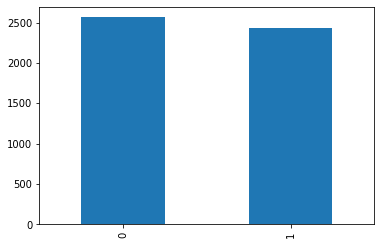

In [ ]:
train['label'].value_counts().plot(kind='bar')

데이터가 균등하게 분포하는 모습이다. 

## 정규표현식을 통한 전처리
- 한글만 남기고 특수문자를 제거해야함.

한글	코드 범위
- ㄱ ~ ㅎ	0x3131 ~ 0x314e
- ㅏ ~ ㅣ	0x314f ~ 0x3163
- 가 ~ 힣	0xac00 ~ 0xd7a3


In [ ]:
train['document'][20:40]

20              처절한 영화, 슬픈 영화, 씁쓸-한 영화...
21         처음부터 끝까지 유치 하기 그지 없다....난해한 영화
22                  전쟁? 아이들의 목소리가 참 거슬린다.
23          멋진 상상력! 아름다운 영화. 여배우 소이의 재발견!
24                       그 시대엔 이 영화가 최고였음
25                       재미없다..애들도 싫어할듯..
26               initiation을 한글로 이니테이션이랜다
27             개빡치게하는드라마!!질퍽거려너 토나올지경이다!!
28               카모메,안경은 재밌었는데..이건 지루하다..
29                  닥터후 시리즈는 뭐다??? 관심이다!!
30           정말 아무것도 할일이 없다면 보세요. 2배속으로..
31    현실적이지도, 그렇다고 환상적이지도 않은 불행한 로맨틱 코미디.
32         소설을 모욕하는 영화, 추상미 자살씬만 기억에 남는다.
33                    ..... 이고은 잊기 울컥ㅜㅜㅜㅡ
34                       왜 영점은없지 일점도 아까운디
35       좋은 의도로 만들었지만 영화내에선 그 의도를 느낄수 없다.
36           눈물흘리면서 봤습니다. 그리스도인들에게 추천합니다!
37                 ㅋㅋㅋ역시 피터잭슨 ㅋㅋㅋ완전재밌어 ㅋㅋ
38        영화평점 작성하신분들 왜케 웃김ㅋㅋㅋ보다가 빵터졌어요ㅋㅋ
39            재밌었어요 스릴도 있었구요 액션신이 기억에 남아요
Name: document, dtype: object

In [ ]:
train['document'] = train['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')
test['document'] = test['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')

In [ ]:
train['document'][20:40]

20                  처절한 영화 슬픈 영화 씁쓸한 영화
21           처음부터 끝까지 유치 하기 그지 없다난해한 영화
22                  전쟁 아이들의 목소리가 참 거슬린다
23           멋진 상상력 아름다운 영화 여배우 소이의 재발견
24                     그 시대엔 이 영화가 최고였음
25                         재미없다애들도 싫어할듯
26                       을 한글로 이니테이션이랜다
27               개빡치게하는드라마질퍽거려너 토나올지경이다
28                  카모메안경은 재밌었는데이건 지루하다
29                     닥터후 시리즈는 뭐다 관심이다
30             정말 아무것도 할일이 없다면 보세요 배속으로
31    현실적이지도 그렇다고 환상적이지도 않은 불행한 로맨틱 코미디
32         소설을 모욕하는 영화 추상미 자살씬만 기억에 남는다
33                        이고은 잊기 울컥ㅜㅜㅜㅡ
34                     왜 영점은없지 일점도 아까운디
35      좋은 의도로 만들었지만 영화내에선 그 의도를 느낄수 없다
36           눈물흘리면서 봤습니다 그리스도인들에게 추천합니다
37               ㅋㅋㅋ역시 피터잭슨 ㅋㅋㅋ완전재밌어 ㅋㅋ
38      영화평점 작성하신분들 왜케 웃김ㅋㅋㅋ보다가 빵터졌어요ㅋㅋ
39          재밌었어요 스릴도 있었구요 액션신이 기억에 남아요
Name: document, dtype: object

In [ ]:
test['document'][:5]

0                    시간 때우기 좋은 영화 지루함
1    훈훈한 정이 느껴지는 영화 가족끼리 드라마 보듯이 보면 딱
2                                    
3                   멋있는 영화입니다 잊을 수 없는
4                  너무 감동적이네요 펑펑 울었습니다
Name: document, dtype: object

### 특수기호는 사라졌는데 영어로쓴 리뷰도 사라졌는데 문제가 되지 않을까?

# 3. 토큰화
토큰화 과정에서 불용어를 제거해보자.
불용어는 의미가 없는 단어니다. 사용자 정의에 따라 더 다양한 불용어를 사용할 수 있다.
파이썬 한국어 형태소 분석 패키지인 KoNLPy가 있는데 이 안에 여러 종류의 한국어 형태소 분석기가 있습니다. 그 중에 OKt 형태소 분석기를 사용하여 제거하였다.

- 형태소 분석기 OKt(Open Korean Text)  
 - 트위터에서 만든 오픈소스 한국어 처리기인 twitter-korean-text를 이어받아 만들고 있는 프로젝트의 분석기
 - 단어들을 알아서 정규화 해주고, 오타도 수정해주는 기능을 가지고 있다

In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.5 MB/s 
     |████████████████████████████████| 448 kB 49.3 MB/s 


In [ ]:
from tqdm import tqdm
from konlpy.tag import Okt
okt = Okt()

불용어 처리과정

In [ ]:
sentence = "괜찮은 음악영화가 또 나왔군요 따뜻한 겨울이 될 것 같아요"

print('1:', sentence)
tokenized_sentence = okt.morphs(sentence, stem=True)  # 토큰화 - 텍스트를 형태소 단위로 나눈다. stem은 각 단어에서 어간을 추출, '괜찮은' 어간인 괜찮다로 추출
print('2:', tokenized_sentence)
tokenized_sentence = okt.morphs(sentence, stem=False)  # 토큰화
print('3:', tokenized_sentence)
stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어를 제거한 문장
print('4:', stopwords_removed_sentence)

1: 괜찮은 음악영화가 또 나왔군요 따뜻한 겨울이 될 것 같아요
2: ['괜찮다', '음악', '영화', '가', '또', '나오다', '따뜻하다', '겨울', '이', '되다', '것', '같다']
3: ['괜찮은', '음악', '영화', '가', '또', '나왔군요', '따뜻한', '겨울', '이', '될', '것', '같아요']
4: ['괜찮은', '음악', '영화', '또', '나왔군요', '따뜻한', '겨울', '될', '것', '같아요']


In [ ]:
X_train = []
okt = Okt()
for sentence in tqdm(train['document']): # document 문장을 가져와서
    tokenized_sentence = okt.morphs(sentence, stem=True)  # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence) 

100%|██████████| 5000/5000 [00:21<00:00, 231.32it/s]


In [ ]:
print(X_train[:3])

[['영상', '이나', '음악', '이쁘다', '해도', '미화', '시키다', '불륜', '일', '뿐'], ['히치콕', '영화', '보다', '분명', '박수', '치다'], ['괜찮다', '음악', '영화', '또', '나오다', '따뜻하다', '겨울', '되다', '것', '같다']]


test 데이터에도 같은 작업 반복

In [ ]:
X_test = []
for sentence in tqdm(test['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 5000/5000 [00:10<00:00, 466.81it/s]


# 정수 인코딩
- 텍스트를 숫자로 바꾸는 기법

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) # 단어 인덱스 구축

In [ ]:
# 단어 mapping 기준은 단어 빈도수 - 자주 나온단어가 1번
print(len(tokenizer.word_index))
for key, rank in tokenizer.word_index.items():
    print("{} : {}".format(rank, key))
    if rank == 10:
        break


6648
1 : 영화
2 : 보다
3 : 없다
4 : 을
5 : 너무
6 : 이다
7 : 좋다
8 : 정말
9 : 재밌다
10 : 있다


등장 빈도수가 낮은 단어가 얼마나 있는지 파악하고 제거 여부를 생각해보자

In [ ]:
for key, value in tokenizer.word_counts.items():
    print(key)
    print(value)
    break

영상
26


In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수 = 6648개
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value 
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1 # 카운트
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 6648
등장 빈도가 2번 이하인 희귀 단어의 수: 4640
단어 집합에서 희귀 단어의 비율: 69.79542719614922
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 13.715559648145007


전체 등장 빈도에서 2번 이하인 희귀 단어 등장 빈도 비율이 13%나 되기 때문에 우리는 등장 빈도가 낮은 친구들을 삭제하지 않겠습니다. 삭제하면 많은 데이터가 삭제되기 때문입니다.

In [ ]:
# 아무것도 삭제 안할거라서 크기는 그대로!
vocab_size = total_cnt
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 6648


texts_to_sequences를 이용하여 정수 시퀀스로 변환

In [ ]:
tokenizer = Tokenizer(vocab_size) # vocab_size: the maximum number of words to keep
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train[:3]

[[256, 192, 182, 238, 619, 929, 329, 930, 196, 151],
 [2009, 1, 2, 746, 931, 377],
 [148, 182, 1, 116, 25, 218, 1560, 16, 30, 21]]

In [ ]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test[:3]

[[42, 723, 7, 1, 321], [791, 1204, 361, 1, 458, 1670, 47, 2, 2, 406], []]

In [ ]:
print(len(X_train)), print(len(X_test))

5000
5000


(None, None)

# 패딩
- 서로 다른 길이의 샘플들의 길이를 동일하게 맞취주는 것을 패딩이라고 합니다.

- 이미지를 다루는 딥러닝에서는 패딩을 이용하여 이미지에 마치 패딩을 입은 것처럼 0 또는 지정 숫자를 둘러주어 정보의 손실을 막습니다.

In [ ]:
print("가장 긴 리뷰의 길이",  max(len(review) for review in X_train))
print('리뷰의 평균길이', sum(map(len, X_train))/len(X_train))

가장 긴 리뷰의 길이 19
리뷰의 평균길이 8.2532


In [ ]:
print("가장 긴 리뷰의 길이",  max(len(review) for review in X_test))
print('리뷰의 평균길이', sum(map(len, X_test))/len(X_test))

가장 긴 리뷰의 길이 18
리뷰의 평균길이 7.5192


train 데이터의 리뷰의 길이 시각화

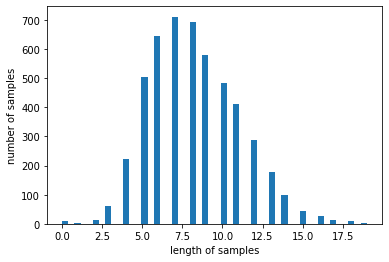

In [ ]:
import matplotlib.pyplot as plt
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# 전체 샘플 중 길이가 %s 이하인 샘플의 비율 함수 정의
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 15 # 임의로 설정해줌
below_threshold_len(max_len, X_train)
below_threshold_len(max_len, X_test)

전체 샘플 중 길이가 15 이하인 샘플의 비율: 98.98
전체 샘플 중 길이가 15 이하인 샘플의 비율: 99.56


샘플 중 길이가 15 이하인 샘플의 비율이 98%나 되기 때문에 15로 길이를 맞춰주어 패딩하겠습니다.

In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
y_train = train['label']

In [ ]:
print(X_train.shape)
print(X_test.shape)

(5000, 15)
(5000, 15)


In [ ]:
X_train[:3]

array([[   0,    0,    0,    0,    0,  256,  192,  182,  238,  619,  929,
         329,  930,  196,  151],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 2009,    1,
           2,  746,  931,  377],
       [   0,    0,    0,    0,    0,  148,  182,    1,  116,   25,  218,
        1560,   16,   30,   21]], dtype=int32)

다음 X_train[:3]를 살펴봤을때 길이가 15개가 안되는 리뷰에 대하여 패딩으로 앞쪽에 0이 들어가있다

# 모델 학습하기

### 간단한 LSTM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path as osp
from konlpy.tag import Okt
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=12, validation_split=0.2)


Epoch 1/15
332/334 [============================>.] - ETA: 0s - loss: 0.4588 - acc: 0.7738
Epoch 00001: val_acc improved from -inf to 0.82900, saving model to best_model.h5
334/334 [==============================] - 13s 29ms/step - loss: 0.4582 - acc: 0.7740 - val_loss: 0.3573 - val_acc: 0.8290
Epoch 2/15
333/334 [============================>.] - ETA: 0s - loss: 0.2500 - acc: 0.8986
Epoch 00002: val_acc improved from 0.82900 to 0.85100, saving model to best_model.h5
334/334 [==============================] - 7s 22ms/step - loss: 0.2498 - acc: 0.8988 - val_loss: 0.3538 - val_acc: 0.8510
Epoch 3/15
334/334 [==============================] - ETA: 0s - loss: 0.1930 - acc: 0.9265
Epoch 00003: val_acc improved from 0.85100 to 0.85900, saving model to best_model.h5
334/334 [==============================] - 7s 22ms/step - loss: 0.1930 - acc: 0.9265 - val_loss: 0.3504 - val_acc: 0.8590
Epoch 4/15
334/334 [==============================] - ETA: 0s - loss: 0.1564 - acc: 0.9390
Epoch 00004: val_

In [ ]:
load_to_model = load_model('best_model.h5')
y_pred = load_to_model.predict(X_test)
y_pred # 0.5를 기준으로 0과 1을 분류

array([[0.02392766],
       [0.99336535],
       [0.6032882 ],
       ...,
       [0.99988407],
       [0.08407113],
       [0.991274  ]], dtype=float32)

In [ ]:
for i in range(len(y_pred)):
  if y_pred[i] < 0.5:
    y_pred[i] = 0
  else:
    y_pred[i]=1
y_pred

array([[0.],
       [1.],
       [1.],
       ...,
       [1.],
       [0.],
       [1.]], dtype=float32)

In [ ]:
submission['label'] = y_pred
submission.to_csv("LSTM(1).csv", index=False) # 0.8415

X_test에 대한 긍/부정 결과가 84.15 accuracy로 무난히 나왔는데 LSTM은 딥러닝 모형이니 추가적으로 layer를 추가하였을때는 결과값이 어떻게 변하는지 살펴봅시다.

### LSTM 개선
- layer 추가 LSTM

In [ ]:
'''
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))
'''
embedding_dim = 1000
embedding_dim2 = 64
embedding_dim3 = 32
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(embedding_dim2))
model.add(Dense(embedding_dim3))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=12, validation_split=0.2)

Epoch 1/15
334/334 [==============================] - ETA: 0s - loss: 0.4062 - acc: 0.8105
Epoch 00001: val_acc improved from -inf to 0.84200, saving model to best_model.h5
334/334 [==============================] - 31s 84ms/step - loss: 0.4062 - acc: 0.8105 - val_loss: 0.3422 - val_acc: 0.8420
Epoch 2/15
334/334 [==============================] - ETA: 0s - loss: 0.2029 - acc: 0.9208
Epoch 00002: val_acc improved from 0.84200 to 0.85500, saving model to best_model.h5
334/334 [==============================] - 27s 81ms/step - loss: 0.2029 - acc: 0.9208 - val_loss: 0.3792 - val_acc: 0.8550
Epoch 3/15
334/334 [==============================] - ETA: 0s - loss: 0.1374 - acc: 0.9477
Epoch 00003: val_acc improved from 0.85500 to 0.85600, saving model to best_model.h5
334/334 [==============================] - 27s 80ms/step - loss: 0.1374 - acc: 0.9477 - val_loss: 0.4070 - val_acc: 0.8560
Epoch 4/15
334/334 [==============================] - ETA: 0s - loss: 0.0843 - acc: 0.9660
Epoch 00004: va

In [ ]:
#load_to_model = load_model('best_model.h5')
y_pred = model.predict(X_test)
for i in range(len(y_pred)):
  if y_pred[i] < 0.5:
    y_pred[i] = 0
  else:
    y_pred[i]=1

In [ ]:
submission['label'] = y_pred
submission.to_csv("LSTM(2).csv", index=False) # 0.8495

Refence
- https://m.blog.naver.com/zzangdol57/221546199789